In [77]:
import re
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [78]:
file_path = tf.keras.utils.get_file(
    'train.txt',
    'https://raw.githubusercontent.com/Franck-Dernoncourt/NeuroNER/master/neuroner/data/conll2003/en/train.txt'
)

In [79]:
for line in open(file_path, 'r').readlines()[:20]:
    print(repr(line))

'-DOCSTART- -X- -X- O\n'
'\n'
'EU NNP B-NP B-ORG\n'
'rejects VBZ B-VP O\n'
'German JJ B-NP B-MISC\n'
'call NN I-NP O\n'
'to TO B-VP O\n'
'boycott VB I-VP O\n'
'British JJ B-NP B-MISC\n'
'lamb NN I-NP O\n'
'. . O O\n'
'\n'
'Peter NNP B-NP B-PER\n'
'Blackburn NNP I-NP I-PER\n'
'\n'
'BRUSSELS NNP B-NP B-LOC\n'
'1996-08-22 CD I-NP O\n'
'\n'
'The DT B-NP O\n'
'European NNP I-NP B-ORG\n'


In [80]:
tagged_sentences = []
sentence = []
for line in open(file_path, 'r'):
    if len(line) == 0 or line.startswith('-DOCSTART') or line[0] == '\n':
        if len(sentence) > 0:
            tagged_sentences.append(sentence)
            sentence = []
        continue 
    word, pos_tag, chunk_tag, ner = line.split(' ')
    ner = re.sub('\n', '', ner)
    word = word.lower()
    sentence.append((word, ner))

In [81]:
len(tagged_sentences), tagged_sentences[:3]

(14041,
 [[('eu', 'B-ORG'),
   ('rejects', 'O'),
   ('german', 'B-MISC'),
   ('call', 'O'),
   ('to', 'O'),
   ('boycott', 'O'),
   ('british', 'B-MISC'),
   ('lamb', 'O'),
   ('.', 'O')],
  [('peter', 'B-PER'), ('blackburn', 'I-PER')],
  [('brussels', 'B-LOC'), ('1996-08-22', 'O')]])

In [82]:
inputs, labels = [], []
for pairs in tagged_sentences:
    words, tags = zip(*pairs)
    inputs.append(list(words))
    labels.append(list(tags))

In [83]:
len(inputs), inputs[0], len(labels), labels[0]

(14041,
 ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.'],
 14041,
 ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O'])

max sample length: 113
mean sample length: 14.501887329962253


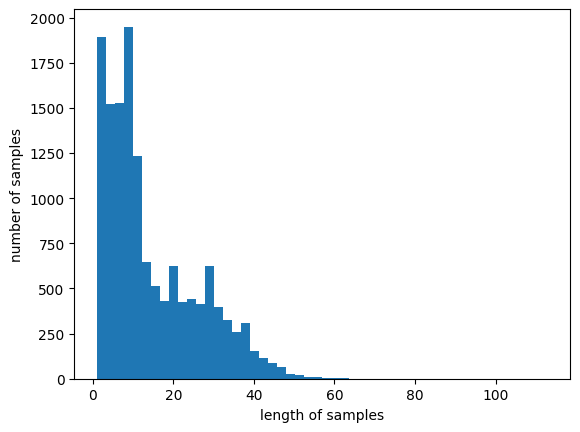

In [84]:
print(f'max sample length: {max([len(w) for w in inputs])}')
print(f'mean sample length: {np.mean([len(w) for w in inputs])}')
plt.hist([len(seq) for seq in inputs], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [85]:
MAX_LENGTH = 60

In [86]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(inputs)
print(len(tokenizer.word_index))

21009


In [87]:
MAX_WORDS = 4_000

In [88]:
train_sentences, test_sentences, train_tags, test_tags \
        = train_test_split(inputs, labels, test_size=0.2)
len(train_sentences), len(test_sentences), len(train_tags), len(test_tags)

(11232, 2809, 11232, 2809)

In [89]:
entity_tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
entity_tokenizer.fit_on_texts(train_sentences)
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(labels)
vocab_size = entity_tokenizer.num_words + 1
tag_size = len(tag_tokenizer.word_index) + 1

vocab_size, tag_size

(4001, 10)

In [90]:
entity_tokenizer.word_index

{'<OOV>': 1,
 'the': 2,
 '.': 3,
 ',': 4,
 'of': 5,
 'in': 6,
 'to': 7,
 'a': 8,
 '(': 9,
 ')': 10,
 'and': 11,
 '"': 12,
 'on': 13,
 'said': 14,
 "'s": 15,
 'for': 16,
 '1': 17,
 '-': 18,
 'was': 19,
 'at': 20,
 '2': 21,
 '0': 22,
 '3': 23,
 'with': 24,
 'that': 25,
 'he': 26,
 'from': 27,
 'it': 28,
 'by': 29,
 ':': 30,
 'is': 31,
 'as': 32,
 '4': 33,
 'had': 34,
 'his': 35,
 'an': 36,
 'has': 37,
 'not': 38,
 'but': 39,
 'be': 40,
 'were': 41,
 'after': 42,
 'have': 43,
 'first': 44,
 'new': 45,
 'who': 46,
 'will': 47,
 '5': 48,
 'they': 49,
 'two': 50,
 'u.s.': 51,
 'been': 52,
 'their': 53,
 'beat': 54,
 '$': 55,
 '--': 56,
 'are': 57,
 '6': 58,
 'up': 59,
 'would': 60,
 'this': 61,
 'year': 62,
 'which': 63,
 'percent': 64,
 'i': 65,
 'its': 66,
 'last': 67,
 'out': 68,
 'one': 69,
 'thursday': 70,
 'million': 71,
 'we': 72,
 'government': 73,
 'over': 74,
 'wednesday': 75,
 'police': 76,
 '7': 77,
 'results': 78,
 'against': 79,
 'second': 80,
 'when': 81,
 'also': 82,
 '/': 83

In [91]:
tag_tokenizer.word_index

{'o': 1,
 'b-loc': 2,
 'b-per': 3,
 'b-org': 4,
 'i-per': 5,
 'i-org': 6,
 'b-misc': 7,
 'i-loc': 8,
 'i-misc': 9}

In [92]:
X_train = entity_tokenizer.texts_to_sequences(train_sentences)
y_train = tag_tokenizer.texts_to_sequences(train_tags)
X_test = entity_tokenizer.texts_to_sequences(test_sentences)
y_test = tag_tokenizer.texts_to_sequences(test_tags)

len(X_train), len(y_train), len(X_test), len(y_test)

(11232, 11232, 2809, 2809)

In [93]:
X_train[0], y_train[0]

([56, 1538, 3908, 190, 41, 167, 1, 20, 1, 3], [1, 4, 6, 1, 1, 1, 1, 1, 1, 1])

In [94]:
X_train_padded = pad_sequences(X_train, maxlen=MAX_LENGTH, padding='post')
y_train_padded = pad_sequences(y_train, maxlen=MAX_LENGTH, padding='post')
X_test_padded = pad_sequences(X_test, maxlen=MAX_LENGTH, padding='post')
y_test_padded = pad_sequences(y_test, maxlen=MAX_LENGTH, padding='post')

X_train_padded[0], y_train_padded[0], X_test_padded[0], y_test_padded[0]

(array([  56, 1538, 3908,  190,   41,  167,    1,   20,    1,    3,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0], dtype=int32),
 array([1, 4, 6, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([  1,   1,   9, 376,  10,  17,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0], dtype=int32),
 ar

In [95]:
y_train_onehot = to_categorical(y_train_padded, tag_size)
y_test_onehot = to_categorical(y_test_padded, tag_size)

y_train_onehot[0], y_test_onehot[0]

(array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],


In [96]:
model = Sequential()
model.add(Embedding(vocab_size, 128))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dense(tag_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 128)         512128    
                                                                 
 bidirectional_2 (Bidirecti  (None, None, 512)         788480    
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, None, 10)          5130      
                                                                 
Total params: 1305738 (4.98 MB)
Trainable params: 1305738 (4.98 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [97]:
model.fit(
    X_train_padded, 
    y_train_onehot, 
    batch_size=128, 
    epochs=10,
    validation_data=(X_test_padded, y_test_onehot)
)

Epoch 1/10


88/88 [==============================] - 17s 156ms/step - loss: 0.3912 - accuracy: 0.9132 - val_loss: 0.2009 - val_accuracy: 0.9577
Epoch 2/10
88/88 [==============================] - 9s 101ms/step - loss: 0.1777 - accuracy: 0.9593 - val_loss: 0.1466 - val_accuracy: 0.9597
Epoch 3/10
88/88 [==============================] - 6s 73ms/step - loss: 0.1201 - accuracy: 0.9645 - val_loss: 0.1062 - val_accuracy: 0.9687
Epoch 4/10
88/88 [==============================] - 6s 68ms/step - loss: 0.0933 - accuracy: 0.9722 - val_loss: 0.0893 - val_accuracy: 0.9745
Epoch 5/10
88/88 [==============================] - 3s 37ms/step - loss: 0.0760 - accuracy: 0.9776 - val_loss: 0.0760 - val_accuracy: 0.9783
Epoch 6/10
88/88 [==============================] - 4s 41ms/step - loss: 0.0604 - accuracy: 0.9825 - val_loss: 0.0627 - val_accuracy: 0.9822
Epoch 7/10
88/88 [==============================] - 3s 33ms/step - loss: 0.0477 - accuracy: 0.9865 - val_loss: 0.0529 - val_accuracy: 0.9854
Epoch 8/10
88/88 [===

In [106]:
scores = model.evaluate(X_test_padded, y_test_onehot, verbose=0)
print(f'{model.metrics_names[0]}: {scores[0]}')
print(f'{model.metrics_names[1]}: {scores[1] * 100}')

loss: 0.047023922204971313
accuracy: 98.75103831291199


In [99]:
test_sample = ['EU gave German call to take British people']

In [100]:
test_sample_tokenized = entity_tokenizer.texts_to_sequences(test_sample)
test_sample_padded = pad_sequences(test_sample_tokenized, maxlen=MAX_LENGTH, padding='post')
test_sample_padded

array([[1117,  369,  208,  633,    7,  273,  221,   90,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0]], dtype=int32)

In [101]:
index2word = entity_tokenizer.index_word
index2tag = tag_tokenizer.index_word

In [107]:
# EU gave German call to take British people
y_predicted = model.predict(test_sample_padded)
y_pred = y_predicted.argmax(axis=-1)
y_pred.shape, y_pred

1/1 [==============================] - 0s 32ms/step


((1, 60),
 array([[4, 1, 7, 1, 1, 1, 7, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]))

In [103]:
test_sample_tokenized

[[1117, 369, 208, 633, 7, 273, 221, 90]]

In [104]:
for i in range(len(test_sample_tokenized)):
    print(f'####i:{i}####')
    for word, tag in zip([index2word.get(x, '?') for x in test_sample_tokenized[i]],
                                                    [index2tag.get(y, '?') for y in y_pred[i]]):
        if word != '<OOV>' and word != '?' and tag != '?':
            print(f'{word}: {tag.upper()}')

####i:0####
eu: B-ORG
gave: O
german: B-MISC
call: O
to: O
take: O
british: B-MISC
people: O
